# Custom reward analysis

In [1]:
import sys
from pathlib import Path

# Modify this as you wish, used for importing custom project packages, such as `utils`
project_path = str(Path.home()) + "\\Projects\\rlgym_demo"

sys.path.insert(0, project_path)

In [2]:
import numpy as np
from rlgym_analysis.reward_functions import common_rewards, extra_rewards, custom_rewards
from rlgym_analysis import plotting

We set some variables which we are gonna need later on.

In [3]:
arena_positions = plotting.arena_positions

In [4]:
ball_position = np.array([1800, -1800, 400])

In [5]:
ball_side_position = np.array([4096, 0, 93])

In [6]:
player_positions = np.array([[100, 400, 200], [1200, -600, 300]])

## Ball distance from goal wall

### Provided reward

Problem: exponent doesn't work as intended

In [7]:
ball2goalwall_dist_zs = common_rewards.ball_y_coord(arena_positions, exponent=1)

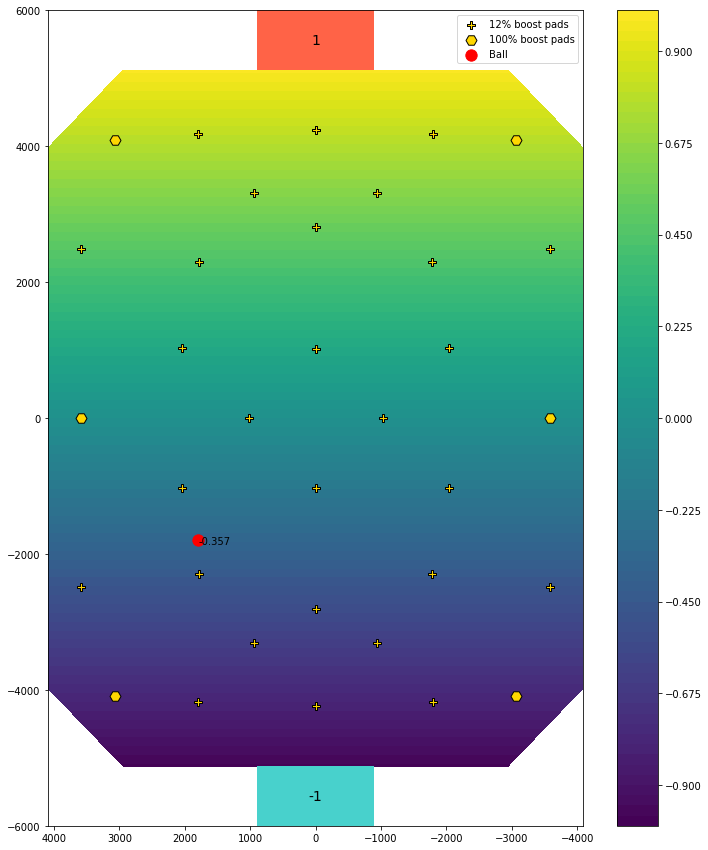

In [8]:
plotting.arena_contour(ball2goalwall_dist_zs, ball_position, annotate_ball=True)

Even exponents produce positive rewards only

In [9]:
ball2goalwall_dist_zs = common_rewards.ball_y_coord(arena_positions, exponent=2)

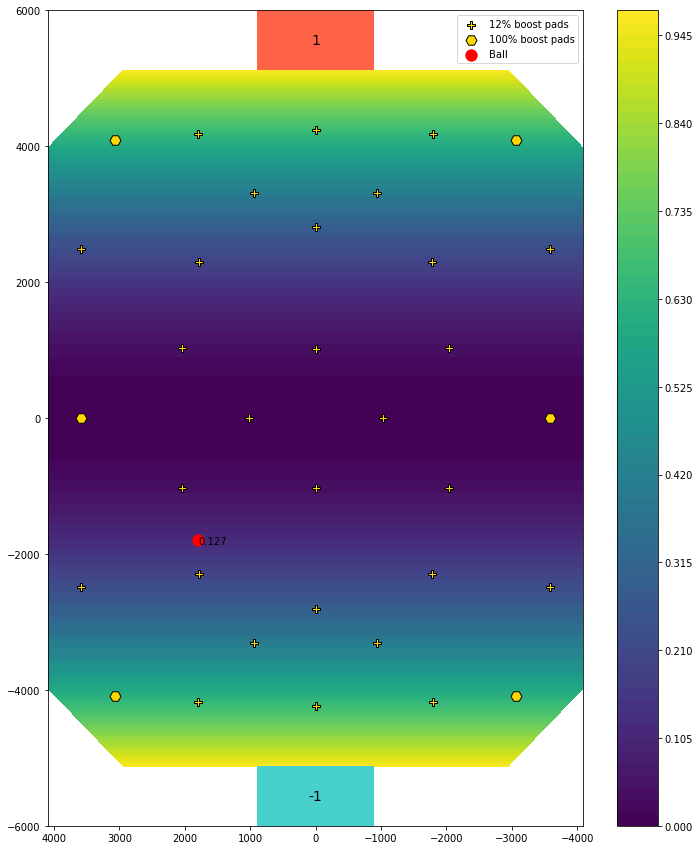

In [10]:
plotting.arena_contour(ball2goalwall_dist_zs, ball_position, annotate_ball=True)

Floating point exponents break reward computation

In [11]:
ball2goalwall_dist_zs = common_rewards.ball_y_coord(arena_positions, exponent=1.3)
ball2goalwall_dist_zs

D:\Anaconda3\envs\rlgym\lib\site-packages\rlgym_analysis\reward_functions\common_rewards\ball_goal.py:29: RuntimeWarning: invalid value encountered in power
  return (ball_position[:, 1] / (common_values.BACK_WALL_Y + common_values.BALL_RADIUS)) ** exponent


array([       nan,        nan,        nan, ..., 0.87550884, 0.88422553,
       0.88422553])

ValueError: z array must not contain non-finite values within the triangulation

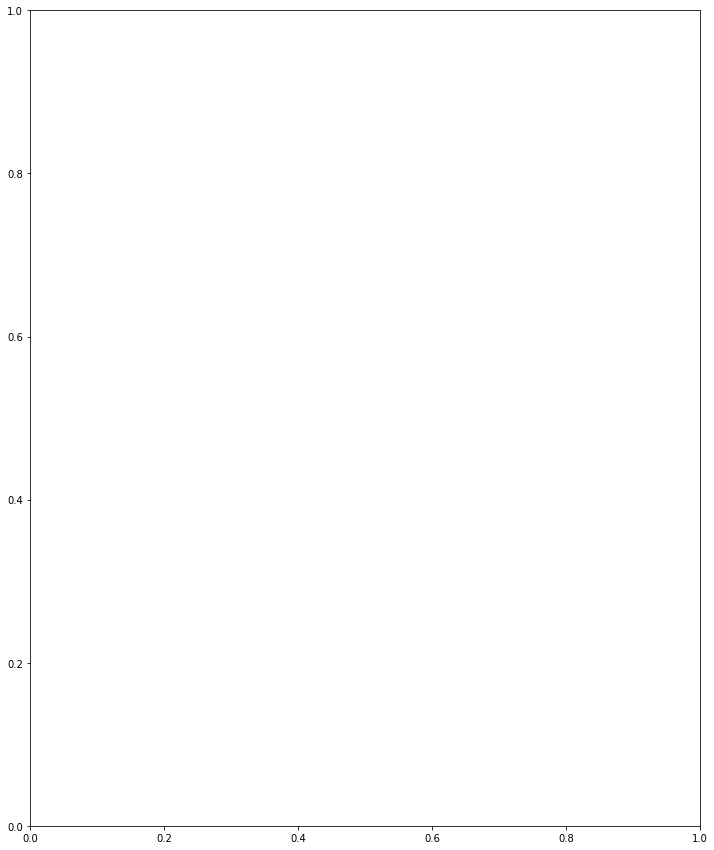

In [12]:
plotting.arena_contour(ball2goalwall_dist_zs, ball_position, annotate_ball=True)

### Custom reward

Exponents fix: raise absolute reward values to the exponent then multiply by the reward sign function value

In [13]:
ball2goalwall_dist_zs = custom_rewards.ball_y_coord(arena_positions, exponent=2)

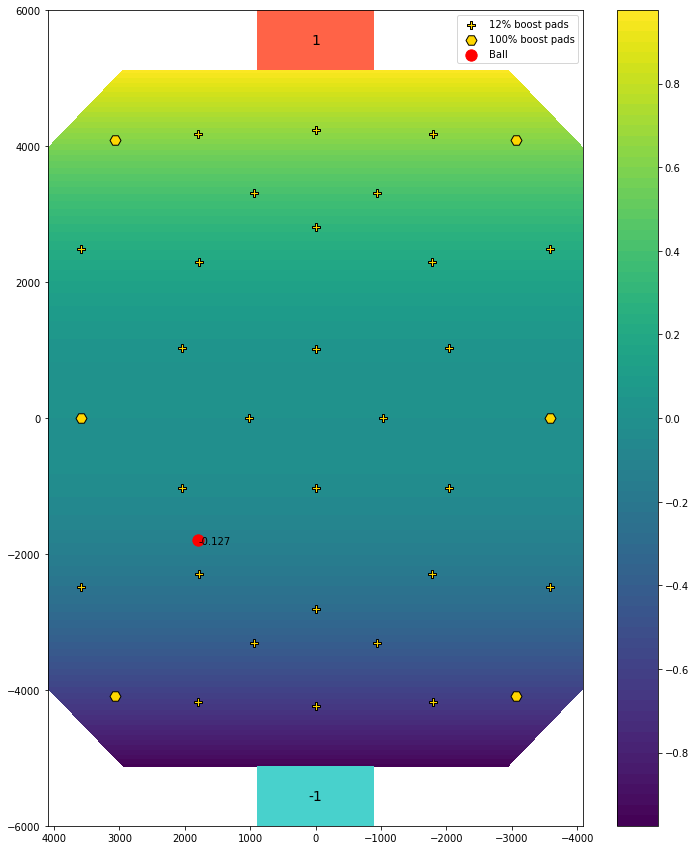

In [14]:
plotting.arena_contour(ball2goalwall_dist_zs, ball_position, annotate_ball=True)

In [15]:
ball2goalwall_dist_zs = custom.ball_y_coord(arena_positions, exponent=1.3)

NameError: name 'custom' is not defined

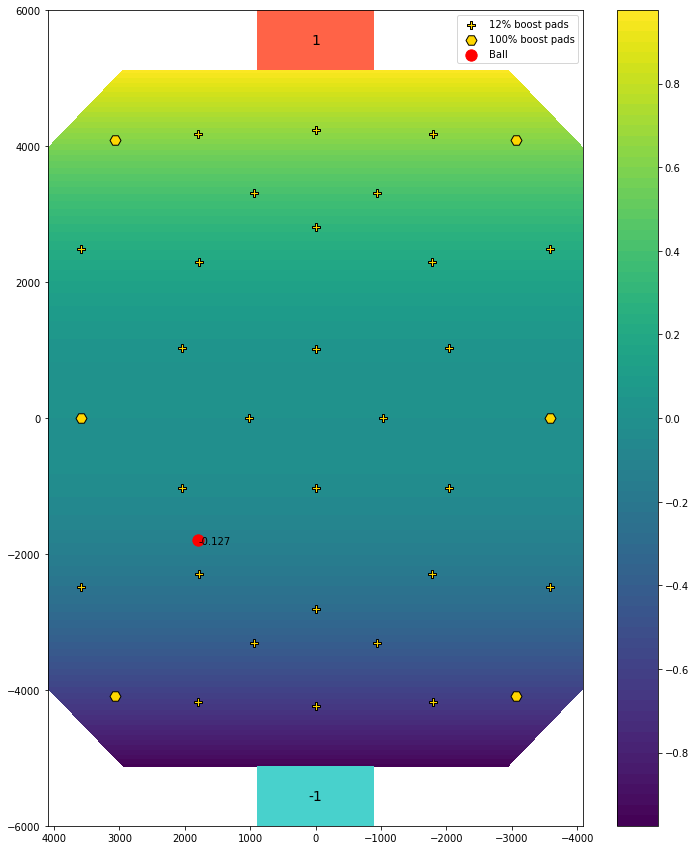

In [16]:
plotting.arena_contour(ball2goalwall_dist_zs, ball_position, annotate_ball=True)

## Difference potential

We prepare some annealed rewards to have something to work with

In [17]:
anneal_steps = [200, 300, 100, 50, 150]
anneal_rews = tuple(np.ones(s) * 2 * i
                    for s, i in zip(np.convolve(anneal_steps, [1, 1]),
                                    range(len(anneal_steps) + 1)))

In [18]:
anneal_zs = extra_rewards.anneal(anneal_rews, anneal_steps)

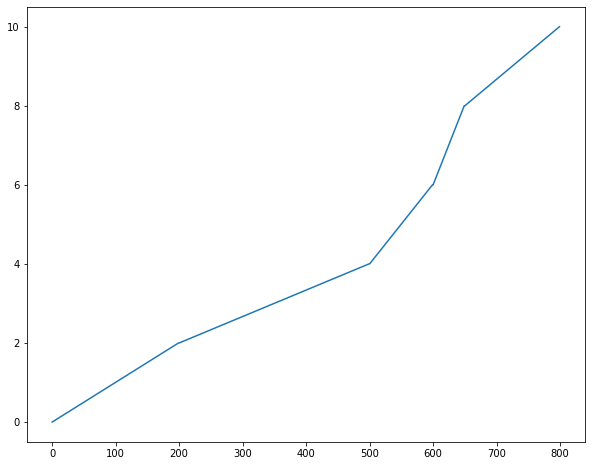

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
plt.plot(anneal_zs)
plt.show()

### Provided reward

Problem: not a potential-based reward shaping function

In [20]:
diff_zs = extra_rewards.diff(anneal_zs)

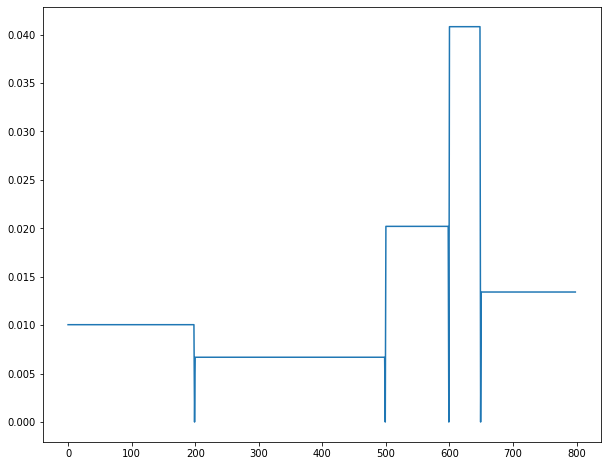

In [21]:
plt.figure(figsize=(10, 8))
plt.plot(diff_zs)
plt.show()

In [22]:
diff_zs = extra_rewards.diff(anneal_zs, negative_slope=3)

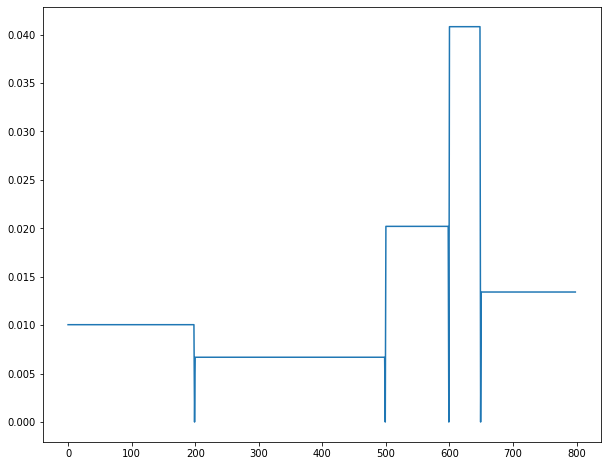

In [23]:
plt.figure(figsize=(10, 8))
plt.plot(diff_zs)
plt.show()

### Custom reward

Fix: extend with a gamma value

In [24]:
diff_zs = custom_rewards.diff_potential(anneal_zs, gamma=0.99, negative_slope=2)

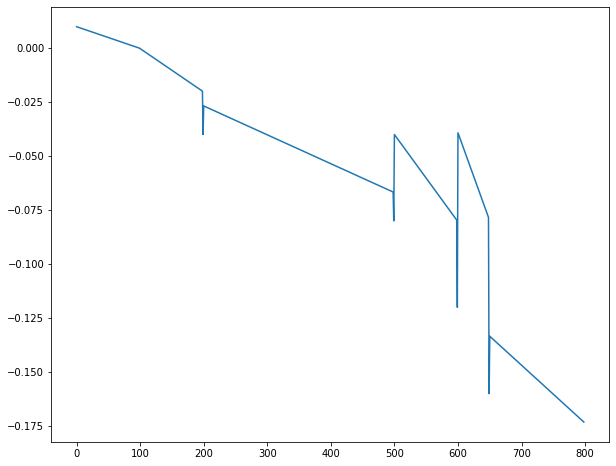

In [25]:
plt.figure(figsize=(10, 8))
plt.plot(diff_zs)
plt.show()

The plot gets more and more similar to the original difference reward as gamma approaches 1.

In [26]:
diff_zs = custom_rewards.diff_potential(anneal_zs, gamma=0.995, negative_slope=1.2)

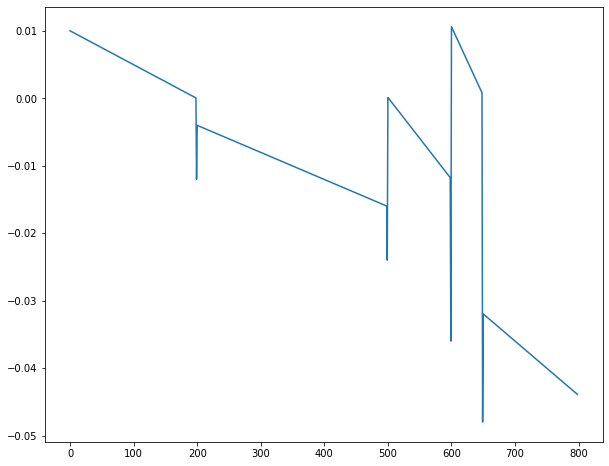

In [27]:
plt.figure(figsize=(10, 8))
plt.plot(diff_zs)
plt.show()

## Event

### Provided reward

Problem: no demoed reward

In [28]:
common_rewards.event(([100, 60, -100, 5, 25, 35, 10],))

135

### Custom reward

Fix: added demoed reward

In [29]:
custom_rewards.event(([100, 60, -100, 5, 25, 35, 10, -10],))

125

## Player distance from ball

### Provided reward

Problem: How can we furtherly control the shape of the reward function?

In [30]:
player2ball_zs = common_rewards.liu_dist_player2ball(arena_positions, ball_side_position)

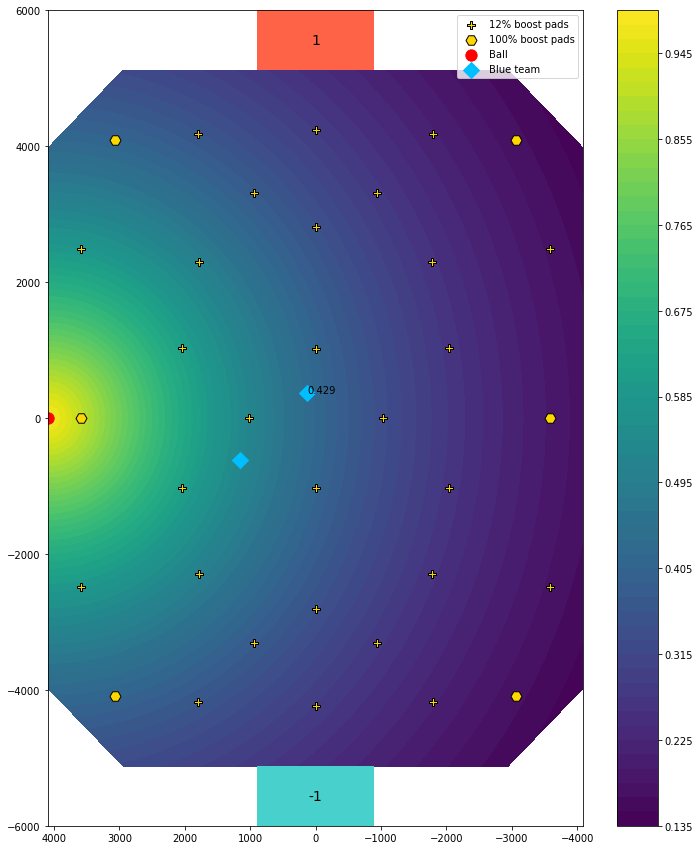

In [31]:
plotting.arena_contour(player2ball_zs, ball_side_position, player_positions=player_positions)

### Custom reward

Solutions:
- Dispersion factor: 
    - when smaller than 1, large rewards are concentrated near the ball
    - when larger than 1, large rewards extend further from the ball
- Density factor:
    - when smaller than 1, the rewards get smaller in general
    - when larger than 1, the rewards get larger in general

In [32]:
player2ball_zs = custom_rewards.liu_dist_player2ball(arena_positions, ball_side_position, dispersion=1, density=1)

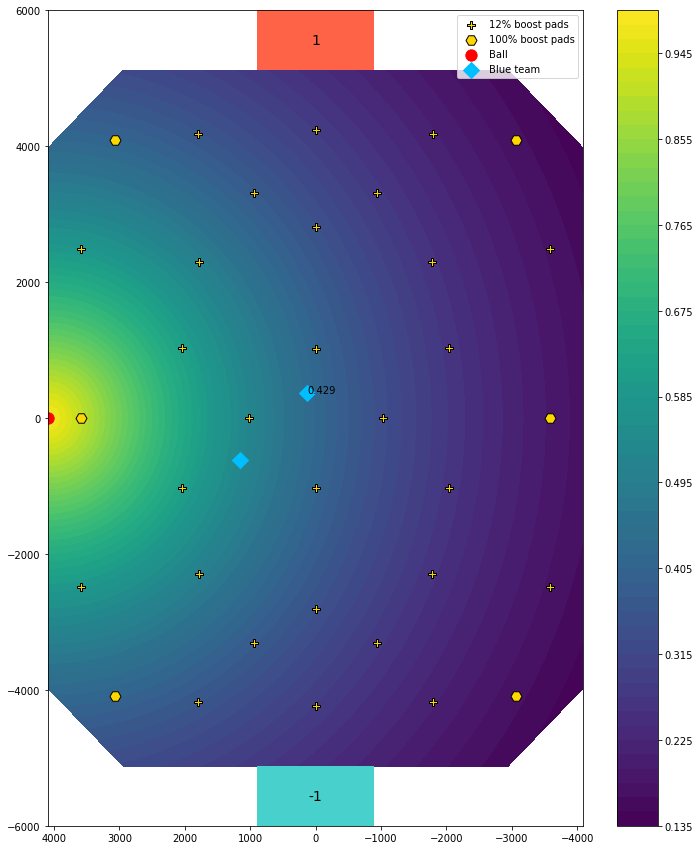

In [33]:
plotting.arena_contour(player2ball_zs, ball_side_position, player_positions=player_positions)

In [34]:
player2ball_zs = custom_rewards.liu_dist_player2ball(arena_positions, ball_side_position, dispersion=0.8, density=1)

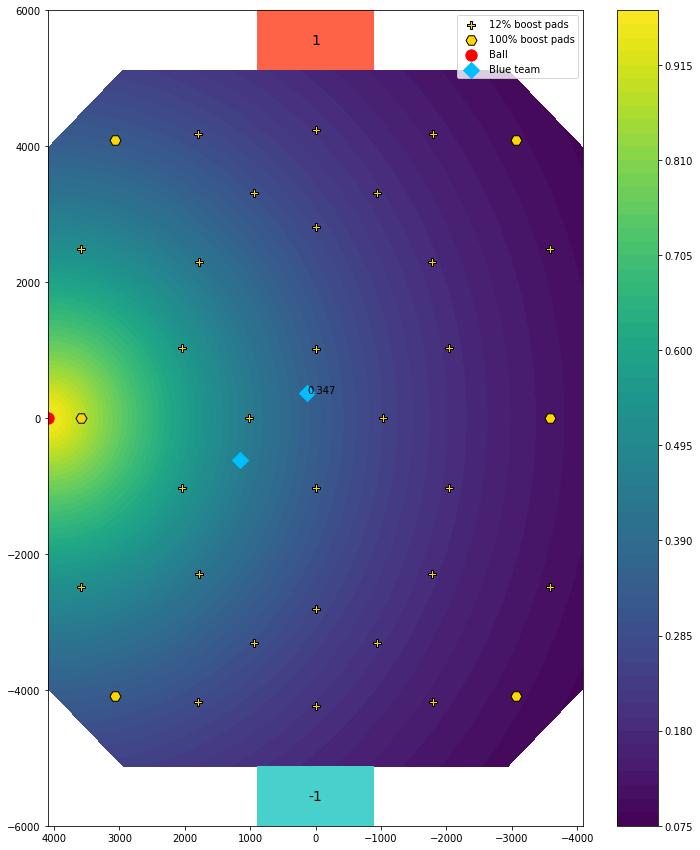

In [35]:
plotting.arena_contour(player2ball_zs, ball_side_position, player_positions=player_positions)

In [36]:
player2ball_zs = custom_rewards.liu_dist_player2ball(arena_positions, ball_side_position, dispersion=0.8, density=3)

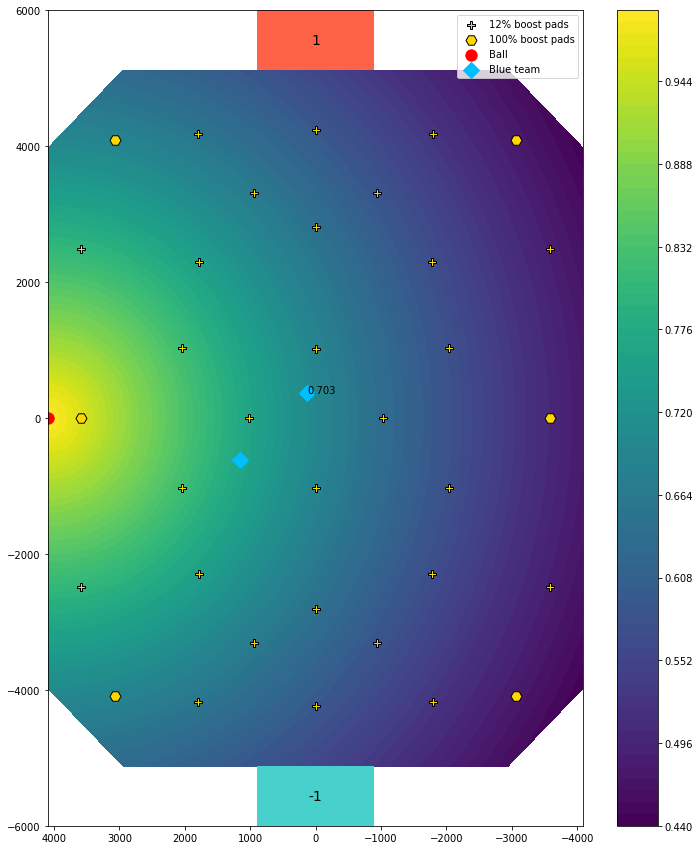

In [37]:
plotting.arena_contour(player2ball_zs, ball_side_position, player_positions=player_positions)

## Ball distance from goal

### Provided reward

Problem: Positive rewards only. We want to reward negative values when the ball gets near the team goal.

In [38]:
ball2goal_zs = common_rewards.liu_dist_ball2goal(arena_positions)

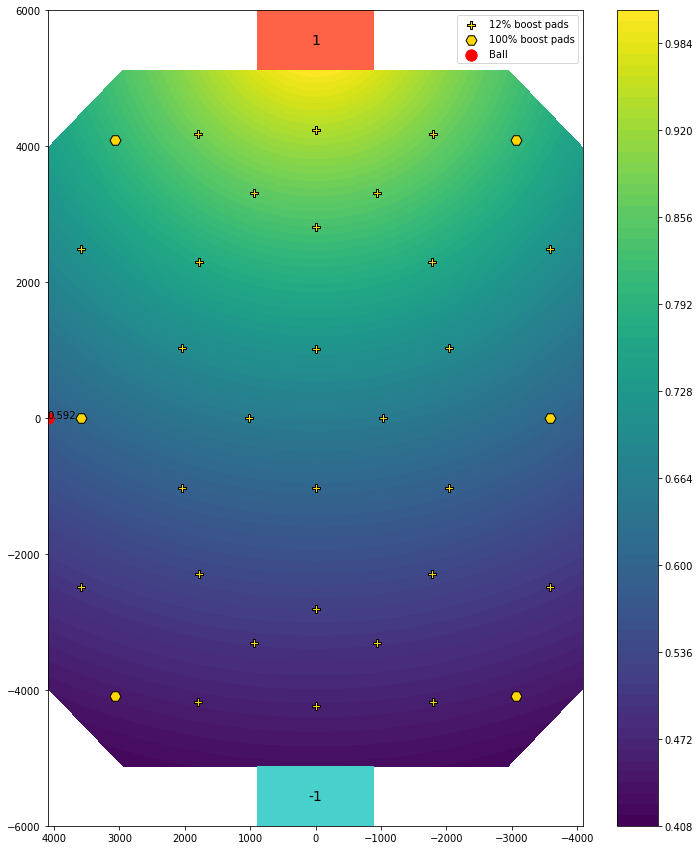

In [39]:
plotting.arena_contour(ball2goal_zs, ball_side_position, annotate_ball=True)

### Custom reward

Solution: Make the distance reward a signed reward that receives a reward of 0 near the mid line.

Additionally, add dispersion and density factors in order to control the shape of the reward.

When the ball is at position `[<side wall>, <mid line>, <ball radius>]` and dispersion and density are 1, we reward with a value close to 0.

In [40]:
ball2goal_zs = custom_rewards.signed_liu_dist_ball2goal(arena_positions)

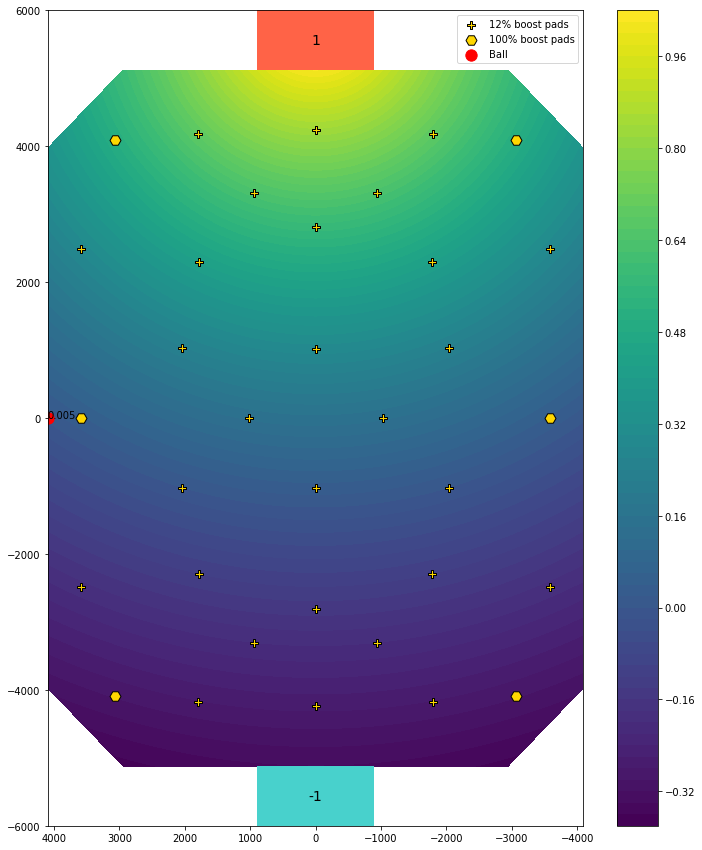

In [41]:
plotting.arena_contour(ball2goal_zs, ball_side_position, annotate_ball=True)

A large density value can help us detect the positive to negative reward value change in the arena better.

In [42]:
ball2goal_zs = custom_rewards.signed_liu_dist_ball2goal(arena_positions, density=4)

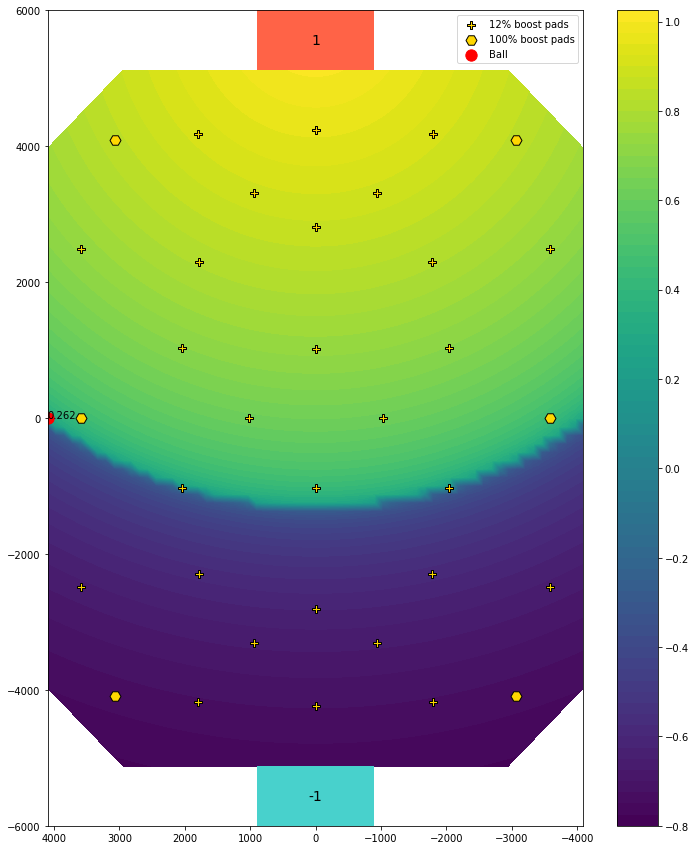

In [43]:
plotting.arena_contour(ball2goal_zs, ball_side_position, annotate_ball=True)

In [44]:
ball2goal_zs = custom_rewards.signed_liu_dist_ball2goal(arena_positions, dispersion=1.3, density=4)

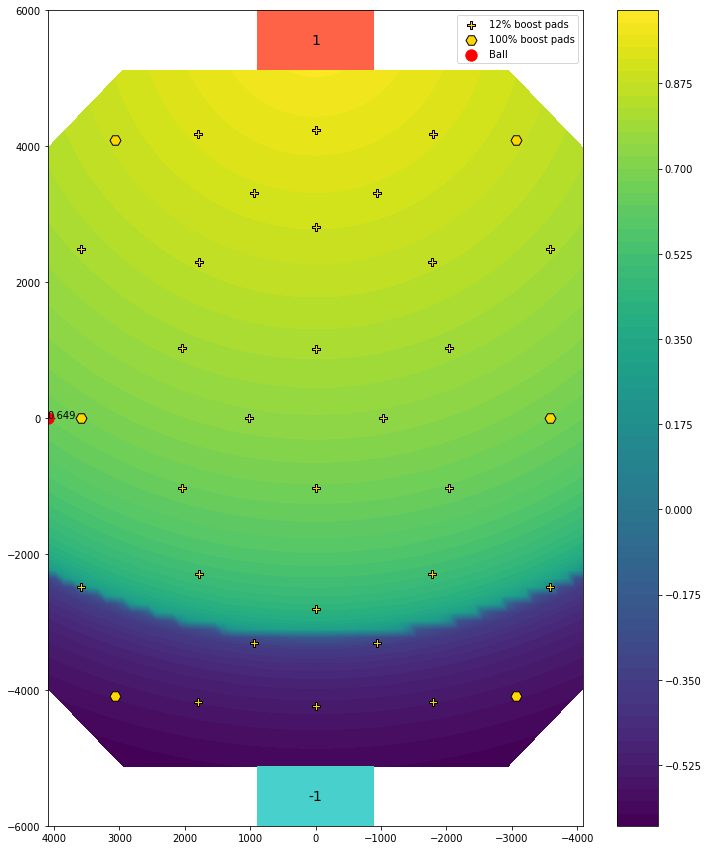

In [45]:
plotting.arena_contour(ball2goal_zs, ball_side_position, annotate_ball=True)

In [46]:
ball2goal_zs = custom_rewards.signed_liu_dist_ball2goal(arena_positions, dispersion=0.9, density=3)

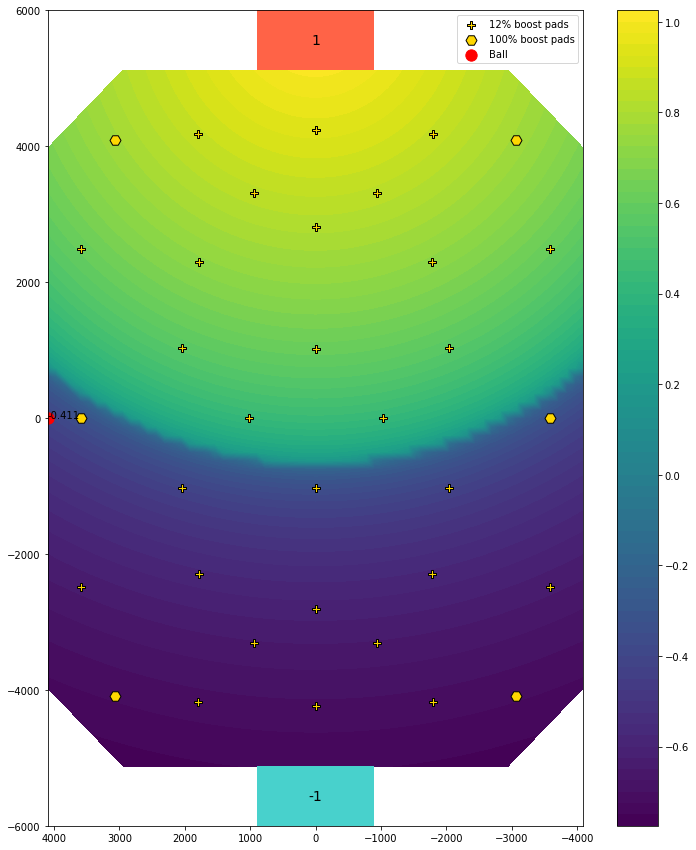

In [47]:
plotting.arena_contour(ball2goal_zs, ball_side_position, annotate_ball=True)